# MIMO PI Controller

In [31]:
import autograd.numpy as np
import capytaine as cpy
import matplotlib.pyplot as plt
import pandas as pd

import wecopttool as wot

wot.set_loglevel("ERROR")


## 0. Parameters

In [2]:
distance = 1.5 # diameters
electrical = False
regular_wave = True
amplitude = 0.2  # fp
wavefreq = 0.3   # Hm0


## 1. BEM Coefficients
### Mesh

In [3]:
wb = wot.geom.WaveBot()
mesh_size_factor = 0.5 # 1.0 for default, smaller to refine mesh
mesh = wb.mesh(mesh_size_factor)


### Array DOFs

In [4]:

def array_of_two(mesh, distance):
    fb_base = cpy.FloatingBody.from_meshio(mesh)
    fb_base.add_translation_dof(name="Heave")
    diameter = 1.76 # m
    Δ = distance * diameter
    fb = fb_base.assemble_arbitrary_array(np.array([
         [0, 0],
         [Δ, 0],
    ]))
    fb.name = "WaveBot Array"
    fb.mesh.name = "WaveBot_01 + WaveBot_02"
    fb.dofs["WaveBot_01_Heave"] = fb.dofs.pop("arbitrary_array_body00__Heave")
    fb.dofs["WaveBot_02_Heave"] = fb.dofs.pop("arbitrary_array_body01__Heave")
    return fb

fb = array_of_two(mesh, distance)
ndof = fb.nb_dofs


### Hydrostatics

In [5]:
hydro_stiffness = wot.hydrostatics.stiffness_matrix(fb).values  # N/m
print(f"hydro_stiffness (N/m):\n{hydro_stiffness}")


hydro_stiffness (N/m):
[[24393.0270237     0.       ]
 [    0.        24393.0270237]]


In [6]:
fb_base = cpy.FloatingBody.from_meshio(mesh)
fb_base.add_translation_dof(name="Heave")
mass_base = wot.hydrostatics.inertia_matrix(fb_base).values[0,0]  # kg
mass_base
mass = np.diag([mass_base, mass_base])

print(f"mass (kg):\n{mass}")


mass (kg):
[[874.38566396   0.        ]
 [  0.         874.38566396]]


### Frequencies

In [7]:
f1 = 0.05  # Hz
nfreq = 50
freq = wot.frequency(f1, nfreq, False)


### BEM

In [8]:
bem_data = wot.run_bem(fb, freq)


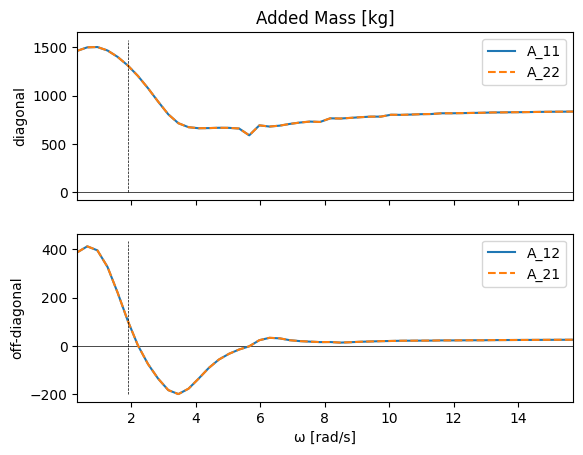

In [9]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ω = bem_data.omega
A_11 = bem_data.added_mass.sel(influenced_dof="WaveBot_01_Heave", radiating_dof="WaveBot_01_Heave")
A_12 = bem_data.added_mass.sel(influenced_dof="WaveBot_01_Heave", radiating_dof="WaveBot_02_Heave")
A_21 = bem_data.added_mass.sel(influenced_dof="WaveBot_02_Heave", radiating_dof="WaveBot_01_Heave")
A_22 = bem_data.added_mass.sel(influenced_dof="WaveBot_02_Heave", radiating_dof="WaveBot_02_Heave")

ax[0].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")
ax[1].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")

ax[0].plot(ω, A_11, label="A_11")
ax[0].plot(ω, A_22, '--', label="A_22")
ax[1].plot(ω, A_12, label="A_12")
ax[1].plot(ω, A_21, '--', label="A_21")

ax[0].set_title("Added Mass [kg]")
ax[0].set_ylabel("diagonal")
ax[1].set_ylabel("off-diagonal")
ax[1].set_xlabel("ω [rad/s]")
ax[0].legend()
ax[1].legend()
ax[1].set_xlim([ω[0], ω[-1]])

ax[0].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [np.min([0, np.min(A_11.values)]), 1.05*np.max(A_11)], 'k--', linewidth=0.5)
ax[1].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [np.min([0, np.min(A_12.values)]), 1.05*np.max(A_12)], 'k--', linewidth=0.5)


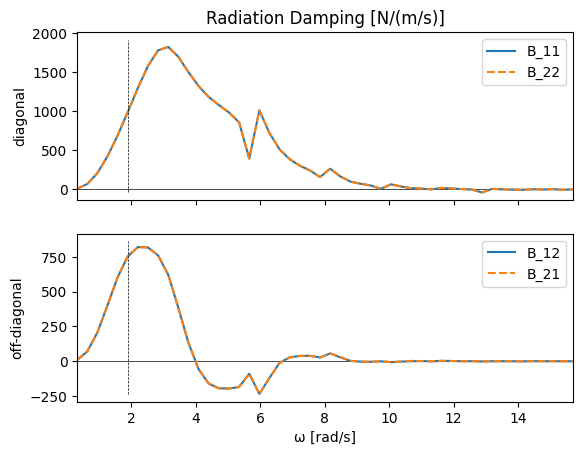

In [10]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

ω = bem_data.omega
B_11 = bem_data.radiation_damping.sel(influenced_dof="WaveBot_01_Heave", radiating_dof="WaveBot_01_Heave")
B_12 = bem_data.radiation_damping.sel(influenced_dof="WaveBot_01_Heave", radiating_dof="WaveBot_02_Heave")
B_21 = bem_data.radiation_damping.sel(influenced_dof="WaveBot_02_Heave", radiating_dof="WaveBot_01_Heave")
B_22 = bem_data.radiation_damping.sel(influenced_dof="WaveBot_02_Heave", radiating_dof="WaveBot_02_Heave")

ax[0].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")
ax[1].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")

ax[0].plot(ω, B_11, label="B_11")
ax[0].plot(ω, B_22, '--', label="B_22")
ax[1].plot(ω, B_12, label="B_12")
ax[1].plot(ω, B_21, '--', label="B_21")

ax[0].set_title("Radiation Damping [N/(m/s)]")
ax[0].set_ylabel("diagonal")
ax[1].set_ylabel("off-diagonal")
ax[1].set_xlabel("ω [rad/s]")
ax[0].legend()
ax[1].legend()
ax[1].set_xlim([ω[0], ω[-1]])

ax[0].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [np.min([0, np.min(B_11.values)]), 1.05*np.max(B_11)], 'k--', linewidth=0.5)
ax[1].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [np.min([0, np.min(B_12.values)]), 1.05*np.max(B_12)], 'k--', linewidth=0.5)


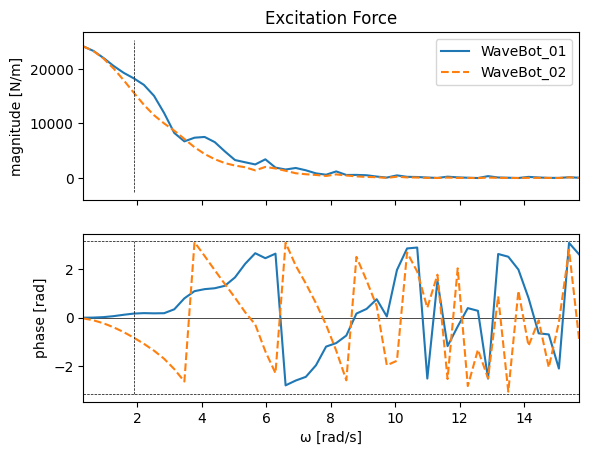

In [11]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)

excitation_force = bem_data.Froude_Krylov_force + bem_data.diffraction_force
F_1 = excitation_force.sel(influenced_dof="WaveBot_01_Heave")
F_2 = excitation_force.sel(influenced_dof="WaveBot_02_Heave")

ax[0].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")
ax[0].plot(ω, np.abs(F_1), label="WaveBot_01")
ax[0].plot(ω, np.abs(F_2), '--', label="WaveBot_02")

ax[1].plot([ω[0], ω[-1]], [0, 0], 'k-', linewidth=0.5, label="_no_label")
ax[1].plot([ω[0], ω[-1]], [np.pi, np.pi], 'k--', linewidth=0.5, label="_no_label")
ax[1].plot([ω[0], ω[-1]], [-np.pi, -np.pi], 'k--', linewidth=0.5, label="_no_label")

ax[1].plot(ω, np.angle(F_1), label="WaveBot_01")
ax[1].plot(ω, np.angle(F_2), '--', label="WaveBot_02")

ax[0].set_title("Excitation Force")
ax[0].set_ylabel("magnitude [N/m]")
ax[1].set_ylabel("phase [rad]")
ax[1].set_xlabel("ω [rad/s]")
ax[1].set_xlim([ω[0], ω[-1]])
ax[0].legend()

ax[0].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [np.min([0, np.min(F_1.values)]), 1.05*np.max(F_1)], 'k--', linewidth=0.5)
ax[1].plot([wavefreq*np.pi*2, wavefreq*np.pi*2], [-np.pi, np.pi], 'k--', linewidth=0.5)


## 2. Common
### PTO

In [12]:
# PTO impedance
if electrical:
    omega = bem_data.omega.values  # rad/s
    gear_ratio = 12.0  # rad/m
    torque_constant = 6.7  # N*m/A
    winding_resistance = 0.5  # Ω
    winding_inductance = 0.0  # H
    drivetrain_inertia = 2.0  # kg*m^2
    drivetrain_friction = 1.0  # N*m*s/rad
    drivetrain_stiffness = 0.0  # N*m/rad

    drivetrain_impedance = (1j*omega*drivetrain_inertia +
                            drivetrain_friction +
                            1/(1j*omega)*drivetrain_stiffness)

    winding_impedance = winding_resistance + 1j*omega*winding_inductance


    pto_impedance_11 = -1* gear_ratio**2 * drivetrain_impedance
    off_diag = np.sqrt(3.0/2.0) * torque_constant * gear_ratio
    pto_impedance_12 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_21 = -1*(off_diag+0j) * np.ones(omega.shape)
    pto_impedance_22 = winding_impedance

    pto_impedance_00 = np.zeros(omega.shape)

    pto_impedance = np.array([
        [pto_impedance_11, pto_impedance_00, pto_impedance_12, pto_impedance_00],
        [pto_impedance_00, pto_impedance_11, pto_impedance_00, pto_impedance_12],
        [pto_impedance_21, pto_impedance_00, pto_impedance_22, pto_impedance_00],
        [pto_impedance_00, pto_impedance_21, pto_impedance_00, pto_impedance_22],
    ])
else:
    pto_impedance = None


In [13]:
# PTO def
pto_name = ['PTO_Heave_01', 'PTO_Heave_02']
kinematics = np.eye(ndof)
loss = None


### Constraints

In [14]:
constraints = []


### Waves

In [15]:
if regular_wave:
    waves = wot.waves.regular_wave(f1, nfreq, wavefreq, amplitude)
else:
    fp = wavefreq
    Hm0 = amplitude
    omnidirectional_spectrum = wot.waves.omnidirectional_spectrum(
        f1=f1,
        nfreq=nfreq,
        spectrum_func=lambda f: wot.waves.jonswap_spectrum(freq=f, fp=fp, hs=Hm0, gamma=3.3),
        spectrum_name="JONSWAP",
    )
    waves = wot.waves.long_crested_wave(omnidirectional_spectrum, 0, seed=13)


### post-process

In [16]:
nsubstep_postprocess = 4


## 3. Solve unstructured

In [17]:
# PTO/controller
pto = wot.pto.PTO(ndof, kinematics, None, pto_impedance, loss, pto_name)

# additional forces
f_add = {'PTO': pto.force_on_wec,}

# WEC object
wec = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add,
)

# objective function
nstate_opt = wot.pto.nstate_unstructured(nfreq, ndof)
obj_fun = pto.average_power

# Solve
scale_x_wec = 1e2
scale_x_opt = 1e0
scale_obj = 1e0

options = {'maxiter': 150}

results = wec.solve(
    waves,
    obj_fun,
    nstate_opt,
    scale_x_wec=scale_x_wec,
    scale_x_opt=scale_x_opt,
    scale_obj=scale_obj,
    optim_options = options,
)

print(f'Optimal average power: {results.fun} W')

# Post-process
wec_fdom, wec_tdom = wec.post_process(results, waves, nsubstep_postprocess)
pto_fdom, pto_tdom = pto.post_process(wec, results, waves, nsubstep_postprocess)

# -3,668 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3668.3915731800234
            Iterations: 109
            Function evaluations: 109
            Gradient evaluations: 109
Optimal average power: -3668.3915731800234 W


## 4. Solve symmetric

In [94]:
# PTO/controller
controller_symm = wot.pto.controller_pi
pto_symm = wot.pto.PTO(ndof, kinematics, controller_symm, pto_impedance, loss, pto_name)

# additional forces
f_add_symm = {'PTO': pto_symm.force_on_wec,}

# WEC object
wec_symm = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_symm,
)

# objective function
nstate_opt_symm = wot.pto.nstate_pid(2, 2, False, True)

if electrical:
    obj_fun_symm = pto_symm.average_power
else:
    obj_fun_symm = pto_symm.mechanical_average_power

# Solve
scale_x_wec_symm = 1e2
scale_x_opt_symm = 1
scale_obj_symm = 1

options_symm = {'maxiter': 300}
x_wec_0_symm = np.ones([wec_symm.nstate_wec]) * 1.5
x_opt_0_symm = np.ones([nstate_opt_symm]) * 1.5

results_symm = wec_symm.solve(
    waves,
    obj_fun_symm,
    nstate_opt_symm,
    scale_x_wec=scale_x_wec_symm,
    scale_x_opt=scale_x_opt_symm,
    scale_obj=scale_obj_symm,
    optim_options = options_symm,
    x_wec_0=x_wec_0_symm,
    x_opt_0=x_opt_0_symm,
)

print(f'Optimal average power (symmetric): {results_symm.fun} W')

# Post-process
wec_fdom_symm, wec_tdom_symm = wec_symm.post_process(results_symm, waves, nsubstep_postprocess)
pto_fdom_symm, pto_tdom_symm = pto_symm.post_process(wec_symm, results_symm, waves, nsubstep_postprocess)

# -3,668 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3668.392514658145
            Iterations: 215
            Function evaluations: 354
            Gradient evaluations: 215
Optimal average power (symmetric): -3668.392514658145 W


## 5. Solve asymmetric

In [47]:
# PTO/controller
def controller_asym(p,w,xw,xo,wa,ns):
    return wot.pto.controller_pi(p,w,xw,xo,wa,ns,symmetric=False)

pto_asym = wot.pto.PTO(ndof, kinematics, controller_asym, pto_impedance, loss, pto_name)

# additional forces
f_add_asym = {'PTO': pto_asym.force_on_wec,}

# WEC object
wec_asym = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_asym,
)

# objective function
nstate_opt_asym = wot.pto.nstate_pid(2, 2, False, False)

if electrical:
    obj_fun_asym = pto_asym.average_power
else:
    obj_fun_asym = pto_asym.mechanical_average_power

# Solve
scale_x_wec_asym = 1e1
scale_x_opt_asym = 1
scale_obj_asym = 1

options_asym = {'maxiter': 300}

results_asym = wec_asym.solve(
    waves,
    obj_fun_asym,
    nstate_opt_asym,
    scale_x_wec=scale_x_wec_asym,
    scale_x_opt=scale_x_opt_asym,
    scale_obj=scale_obj_asym,
    optim_options = options_asym,
)

print(f'Optimal average power (asymmetrical): {results_asym.fun} W')

# Post-process
wec_fdom_asym, wec_tdom_asym = wec_asym.post_process(results_asym, waves, nsubstep_postprocess)
pto_fdom_asym, pto_tdom_asym = pto_asym.post_process(wec_asym, results_asym, waves, nsubstep_postprocess)

# -3,668 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3668.3925146607994
            Iterations: 293
            Function evaluations: 529
            Gradient evaluations: 293
Optimal average power (asymmetrical): -3668.3925146607994 W


## 6. Solve diagonal

In [20]:
# PTO/controller
def controller_diag(pto, wec, x_wec, x_opt, waves=None, nsubsteps=1):
    return wot.pto.controller_pi(pto, wec, x_wec, x_opt, waves, nsubsteps, diagonal_only=True)

pto_diag = wot.pto.PTO(ndof, kinematics, controller_diag, pto_impedance, loss, pto_name)

# additional forces
f_add_diag = {'PTO': pto_diag.force_on_wec,}

# WEC object
wec_diag = wot.WEC.from_bem(bem_data,
                       inertia_matrix=mass,
                       hydrostatic_stiffness=hydro_stiffness,
                       constraints=constraints,
                       friction=None,
                       f_add=f_add_diag,
)

# objective function
nstate_opt_diag = wot.pto.nstate_pid(2, 2, True, False)

if electrical:
    obj_fun_diag = pto_diag.average_power
else:
    obj_fun_diag = pto_diag.mechanical_average_power

# Solve
scale_x_wec_diag = 1e2
scale_x_opt_diag = 1
scale_obj_diag = 1

options_diag = {'maxiter': 300}

results_diag = wec_diag.solve(
    waves,
    obj_fun_diag,
    nstate_opt_diag,
    scale_x_wec=scale_x_wec_diag,
    scale_x_opt=scale_x_opt_diag,
    scale_obj=scale_obj_diag,
    optim_options = options_diag,
)

print(f'Optimal average power (diagonal): {results_diag.fun} W')

# Post-process
wec_fdom_diag, wec_tdom_diag = wec_diag.post_process(results_diag, waves, nsubstep_postprocess)
pto_fdom_diag, pto_tdom_diag = pto_diag.post_process(wec_diag, results_diag, waves, nsubstep_postprocess)

# -3,668 W


Optimization terminated successfully    (Exit mode 0)
            Current function value: -3668.392514660171
            Iterations: 117
            Function evaluations: 180
            Gradient evaluations: 117
Optimal average power (diagonal): -3668.392514660171 W


## 7.Plots

/var/folders/lt/g02nr64n5hb_msyqddwt1_v0002gm1/T/ipykernel_8779/3906754705.py:11: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "-" (-> linestyle='-'). The keyword argument will take precedence.
  ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(ijcolor), label='_nolegend_', linestyle=istyle)


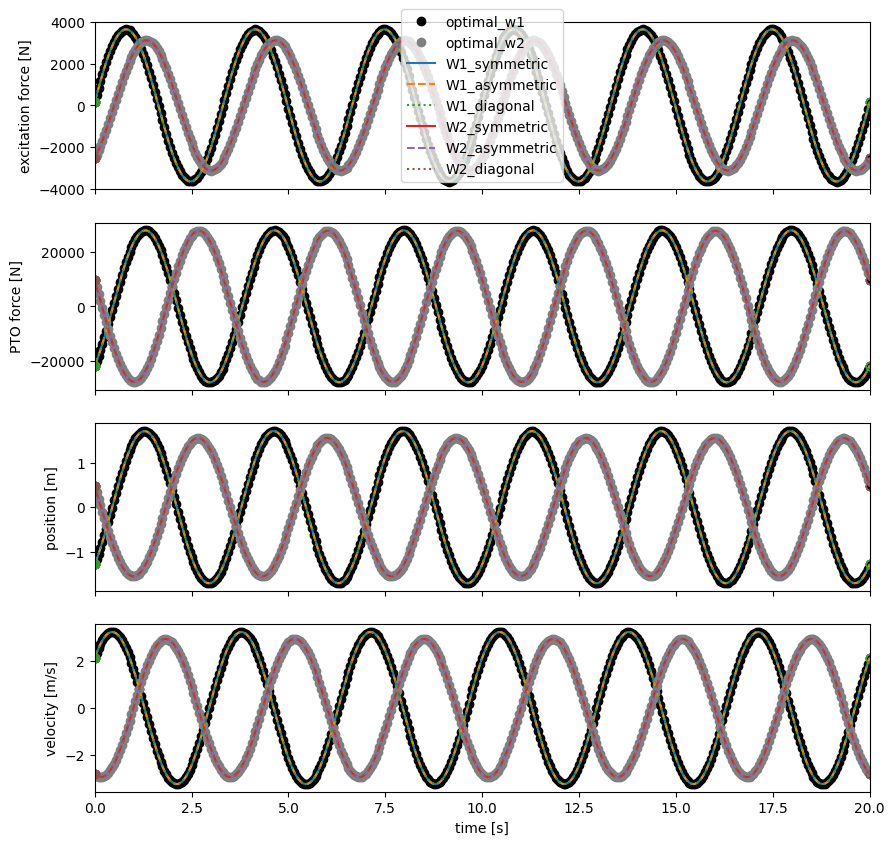

In [95]:
n = 4
fig, ax = plt.subplots(n, 1, sharex=True, figsize=(10,10))
plt.xlim([0, wec_symm.tf])
cmap = plt.get_cmap("tab10")

def _plot(i, y, wec, icolor, jcolor, istyle, ilabel=None):
    ijcolor = jcolor*3 + icolor
    ilabel = '_nolegend' if ilabel is None else ilabel
    ax[i].plot(0, y[0], 'o', color=cmap(ijcolor), label='_nolegend_')
    ax[i].plot(wec.tf, y[0], 'o', color=cmap(ijcolor), markerfacecolor='none', label='_nolegend_')
    ax[i].plot([wec.time_nsubsteps(nsubstep_postprocess)[-1], wec.tf], [y[-1], y[0]], '-', color=cmap(ijcolor), label='_nolegend_', linestyle=istyle)
    y.plot(color=cmap(ijcolor), ax=ax[i], label=ilabel, linestyle=istyle); ax[i].set_xlabel(""); ax[i].set_title("")

icolor_symm, icolor_asym, icolor_diag = 0,1,2
istyle_symm, istyle_asym, istyle_diag = '-', '--', ':'

def _plot_y(y_1, y_2):
    ax[i].plot(0, y_1[0], 'ko', label='_nolegend_')
    ax[i].plot(wec.tf, y_1[0], 'ko', label='_nolegend_')
    y_1.plot(color="k", ax=ax[i], label="optimal_w1", linestyle="none", marker="o"); ax[i].set_xlabel(""); ax[i].set_title("")

    ax[i].plot(0, y_2[0], 'ko', label='_nolegend_')
    ax[i].plot(wec.tf, y_2[0], 'ko', label='_nolegend_')
    y_2.plot(color="0.5", ax=ax[i], label="optimal_w2", linestyle="none", marker="o"); ax[i].set_xlabel(""); ax[i].set_title("")

# excitation force
i = 0

y_1 = np.squeeze(
    wec_tdom['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom['force'].sel(type='diffraction', influenced_dof='DOF_0')
)

y_symm_1 = np.squeeze(
    wec_tdom_symm['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_symm['force'].sel(type='diffraction', influenced_dof='DOF_0')
)
y_asym_1 = np.squeeze(
    wec_tdom_asym['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_asym['force'].sel(type='diffraction', influenced_dof='DOF_0')
)
y_diag_1 = np.squeeze(
    wec_tdom_diag['force'].sel(type='Froude_Krylov', influenced_dof='DOF_0') +
    wec_tdom_diag['force'].sel(type='diffraction', influenced_dof='DOF_0')
)

y_2 = np.squeeze(
    wec_tdom['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom['force'].sel(type='diffraction', influenced_dof='DOF_1')
)

y_symm_2 = np.squeeze(
    wec_tdom_symm['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_symm['force'].sel(type='diffraction', influenced_dof='DOF_1')
)
y_asym_2 = np.squeeze(
    wec_tdom_asym['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_asym['force'].sel(type='diffraction', influenced_dof='DOF_1')
)
y_diag_2 = np.squeeze(
    wec_tdom_diag['force'].sel(type='Froude_Krylov', influenced_dof='DOF_1') +
    wec_tdom_diag['force'].sel(type='diffraction', influenced_dof='DOF_1')
)

_plot_y(y_1, y_2)

_plot(i, y_symm_1, wec_symm, icolor=icolor_symm, jcolor=0, istyle=istyle_symm, ilabel='W1_symmetric')
_plot(i, y_asym_1, wec_asym, icolor=icolor_asym, jcolor=0, istyle=istyle_asym, ilabel='W1_asymmetric')
_plot(i, y_diag_1, wec_diag, icolor=icolor_diag, jcolor=0, istyle=istyle_diag, ilabel='W1_diagonal')

_plot(i, y_symm_2, wec_symm, icolor=icolor_symm, jcolor=1, istyle=istyle_symm, ilabel='W2_symmetric')
_plot(i, y_asym_2, wec_asym, icolor=icolor_asym, jcolor=1, istyle=istyle_asym, ilabel='W2_asymmetric')
_plot(i, y_diag_2, wec_diag, icolor=icolor_diag, jcolor=1, istyle=istyle_diag, ilabel='W2_diagonal')

ax[i].set_ylabel('excitation force [N]')


# PTO force
i = 1

y_1 = np.squeeze(pto_tdom['force'].sel(dof="PTO_Heave_01"))
y_symm_1 = np.squeeze(pto_tdom_symm['force'].sel(dof="PTO_Heave_01"))
y_asym_1 = np.squeeze(pto_tdom_asym['force'].sel(dof="PTO_Heave_01"))
y_diag_1 = np.squeeze(pto_tdom_diag['force'].sel(dof="PTO_Heave_01"))

y_2 = np.squeeze(pto_tdom['force'].sel(dof="PTO_Heave_02"))
y_symm_2 = np.squeeze(pto_tdom_symm['force'].sel(dof="PTO_Heave_02"))
y_asym_2 = np.squeeze(pto_tdom_asym['force'].sel(dof="PTO_Heave_02"))
y_diag_2 = np.squeeze(pto_tdom_diag['force'].sel(dof="PTO_Heave_02"))

_plot_y(y_1, y_2)

_plot(i, y_symm_1, wec_symm, icolor=icolor_symm, jcolor=0, istyle=istyle_symm)
_plot(i, y_asym_1, wec_asym, icolor=icolor_asym, jcolor=0, istyle=istyle_asym)
_plot(i, y_diag_1, wec_diag, icolor=icolor_diag, jcolor=0, istyle=istyle_diag)

_plot(i, y_symm_2, wec_symm, icolor=icolor_symm, jcolor=1, istyle=istyle_symm)
_plot(i, y_asym_2, wec_asym, icolor=icolor_asym, jcolor=1, istyle=istyle_asym)
_plot(i, y_diag_2, wec_diag, icolor=icolor_diag, jcolor=1, istyle=istyle_diag)

ax[i].set_ylabel('PTO force [N]')

# position
i = 2

y_1 = np.squeeze(wec_tdom['pos'].sel(influenced_dof='DOF_0'))
y_symm_1 = np.squeeze(wec_tdom_symm['pos'].sel(influenced_dof='DOF_0'))
y_asym_1 = np.squeeze(wec_tdom_asym['pos'].sel(influenced_dof='DOF_0'))
y_diag_1 = np.squeeze(wec_tdom_diag['pos'].sel(influenced_dof='DOF_0'))

y_2 = np.squeeze(wec_tdom['pos'].sel(influenced_dof='DOF_1'))
y_symm_2 = np.squeeze(wec_tdom_symm['pos'].sel(influenced_dof='DOF_1'))
y_asym_2 = np.squeeze(wec_tdom_asym['pos'].sel(influenced_dof='DOF_1'))
y_diag_2 = np.squeeze(wec_tdom_diag['pos'].sel(influenced_dof='DOF_1'))

_plot_y(y_1, y_2)

_plot(i, y_symm_1, wec_symm, icolor=icolor_symm, jcolor=0, istyle=istyle_symm)
_plot(i, y_asym_1, wec_asym, icolor=icolor_asym, jcolor=0, istyle=istyle_asym)
_plot(i, y_diag_1, wec_diag, icolor=icolor_diag, jcolor=0, istyle=istyle_diag)

_plot(i, y_symm_2, wec_symm, icolor=icolor_symm, jcolor=1, istyle=istyle_symm)
_plot(i, y_asym_2, wec_asym, icolor=icolor_asym, jcolor=1, istyle=istyle_asym)
_plot(i, y_diag_2, wec_diag, icolor=icolor_diag, jcolor=1, istyle=istyle_diag)

ax[i].set_ylabel('position [m]')


# velocity
i = 3

y_1 = np.squeeze(wec_tdom['vel'].sel(influenced_dof='DOF_0'))
y_symm_1 = np.squeeze(wec_tdom_symm['vel'].sel(influenced_dof='DOF_0'))
y_asym_1 = np.squeeze(wec_tdom_asym['vel'].sel(influenced_dof='DOF_0'))
y_diag_1 = np.squeeze(wec_tdom_diag['vel'].sel(influenced_dof='DOF_0'))

y_2 = np.squeeze(wec_tdom['vel'].sel(influenced_dof='DOF_1'))
y_symm_2 = np.squeeze(wec_tdom_symm['vel'].sel(influenced_dof='DOF_1'))
y_asym_2 = np.squeeze(wec_tdom_asym['vel'].sel(influenced_dof='DOF_1'))
y_diag_2 = np.squeeze(wec_tdom_diag['vel'].sel(influenced_dof='DOF_1'))

_plot_y(y_1, y_2)

_plot(i, y_symm_1, wec_symm, icolor=icolor_symm, jcolor=0, istyle=istyle_symm)
_plot(i, y_asym_1, wec_asym, icolor=icolor_asym, jcolor=0, istyle=istyle_asym)
_plot(i, y_diag_1, wec_diag, icolor=icolor_diag, jcolor=0, istyle=istyle_diag)

_plot(i, y_symm_2, wec_symm, icolor=icolor_symm, jcolor=1, istyle=istyle_symm)
_plot(i, y_asym_2, wec_asym, icolor=icolor_asym, jcolor=1, istyle=istyle_asym)
_plot(i, y_diag_2, wec_diag, icolor=icolor_diag, jcolor=1, istyle=istyle_diag)

ax[i].set_ylabel('velocity [m/s]')


#
plt.xlabel("time [s]")
ax[0].legend()


In [96]:
col_labels = ["P_w1", "P_w2", "I_w1", "I_w2"]
row_labels = ["F_w1", "F_w2"]

def get_tab(mp, mi, label):
    tab = pd.DataFrame(np.concatenate([mp, mi],1), columns=col_labels, index=row_labels)
    print(label + ":\n", tab, "\n")
    return tab

# asym
mp_asym = np.reshape(results_asym.x[-nstate_opt_asym:-int(nstate_opt_asym/2)], [ndof, ndof])
mi_asym = np.reshape(results_asym.x[-int(nstate_opt_asym/2):], [ndof, ndof])
tab_asym = get_tab(mp_asym, mi_asym, "asymmetrical")

# symm
v = results_symm.x[-nstate_opt_symm:-int(nstate_opt_symm/2)]
mp_symm = np.diag(v[:ndof],0) + np.diag(v[ndof:ndof+ndof-1],1) + np.diag(v[ndof:ndof+ndof-1],-1)
v = results_symm.x[-int(nstate_opt_symm/2):]
mi_symm = np.diag(v[:ndof],0) + np.diag(v[ndof:ndof+ndof-1],1) + np.diag(v[ndof:ndof+ndof-1],-1)
tab_symm = get_tab(mp_symm, mi_symm, "symmetrical")

# diag
mp_diag = np.diag(results_diag.x[-nstate_opt_diag:-int(nstate_opt_diag/2)])
mi_diag = np.diag(results_diag.x[-int(nstate_opt_diag/2):])
tab_diag = get_tab(mp_diag, mi_diag, "diagonal")


asymmetrical:
               P_w1          P_w2         I_w1          I_w2
F_w1   7802.400913  10328.534070  7457.435023    429.043982
F_w2 -10026.072523 -11512.422969  5424.215981  12175.488356 

symmetrical:
              P_w1         P_w2          I_w1          I_w2
F_w1 -3218.880992    71.680555   7016.762571 -11770.204764
F_w2    71.680555  3180.616854 -11770.204764   6763.188409 

diagonal:
             P_w1       P_w2          I_w1          I_w2
F_w1 -348.418829    0.00000  16247.045708      0.000000
F_w2    0.000000 -428.85688      0.000000  17781.998813 



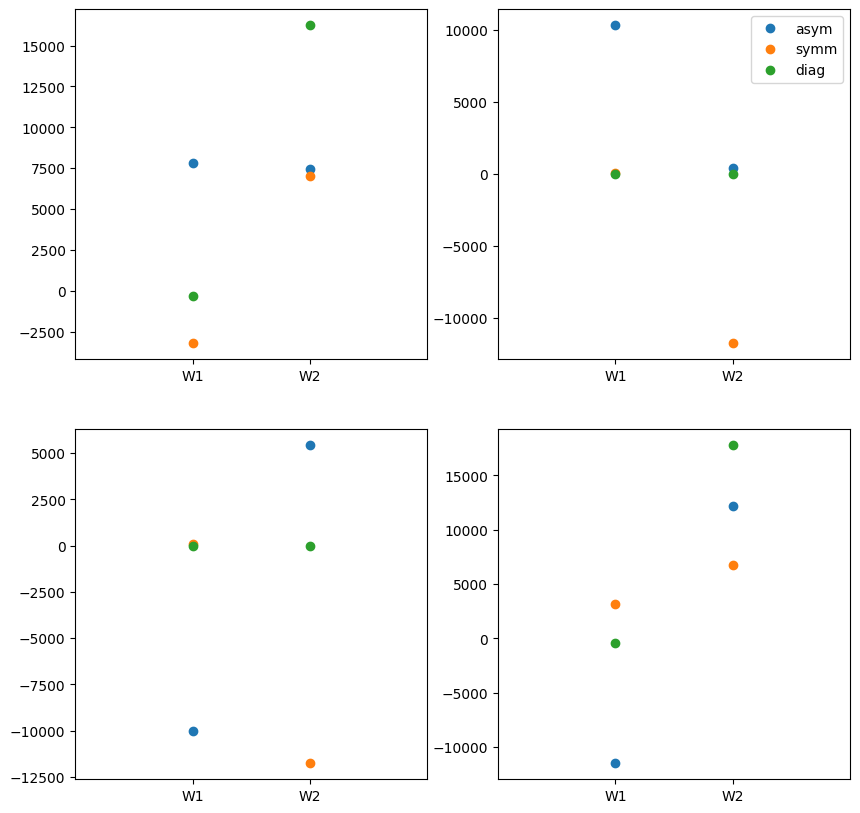

In [97]:
def _plot_gains(tabs, labels):
    fig, ax = plt.subplots(2, 2, figsize=(10,10))

    for i,tab in enumerate(tabs):
        v = tab.values

        ax[0,0].plot([1,], v[0,0], 'o', color=cmap(i), label=labels[i])
        ax[0,1].plot([1,], v[0,1], 'o', color=cmap(i), label=labels[i])
        ax[1,0].plot([1,], v[1,0], 'o', color=cmap(i), label=labels[i])
        ax[1,1].plot([1,], v[1,1], 'o', color=cmap(i), label=labels[i])

        ax[0,0].plot([2,], v[0,2], 'o', color=cmap(i))
        ax[0,1].plot([2,], v[0,3], 'o', color=cmap(i))
        ax[1,0].plot([2,], v[1,2], 'o', color=cmap(i))
        ax[1,1].plot([2,], v[1,3], 'o', color=cmap(i))
    ax[0,1].legend()
    for iax in ax.flatten():
        iax.set_xlim([0,3])
        iax.set_xticks([1,2])
        iax.set_xticklabels(["W1", "W2"])

_plot_gains([tab_asym, tab_symm, tab_diag], ["asym", "symm", "diag"])
